<a href="https://colab.research.google.com/github/konarfil/CalibrationScript/blob/main/100_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Goal


The goal of the project is to predict median housing prices of houses in different parts of California. For this purpose I use dataset from 1990 containing basic information about housing blocks. The dataset can be downloaded here https://www.kaggle.com/datasets/camnugent/california-housing-prices/data.

## Code

In [19]:
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

### Dataset - describe + load + split


In [2]:
# download the dataset for Google Drive
gdown.download("https://drive.google.com/uc?id=1cEQARHqtmLDlgdeA72JHQfew0kYbhAdw", "housing.csv")
df = pd.read_csv("housing.csv")

Downloading...
From: https://drive.google.com/uc?id=1cEQARHqtmLDlgdeA72JHQfew0kYbhAdw
To: /content/housing.csv
100%|██████████| 1.42M/1.42M [00:00<00:00, 51.2MB/s]


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**1. longitude:** A measure of how far west a house is; a higher value is farther west

**2. latitude:** A measure of how far north a house is; a higher value is farther north

**3. housingMedianAge:** Median age of a house within a block; a lower number is a newer building

**4. totalRooms:** Total number of rooms within a block

**5. totalBedrooms:** Total number of bedrooms within a block

**6. population:** Total number of people residing within a block

**7. households:** Total number of households, a group of people residing within a home unit, for a block

**8. medianIncome:** Median income for households within a block of houses (measured in tens of thousands of US Dollars)

**9. medianHouseValue:** Median house value for households within a block (measured in US Dollars)

**10. oceanProximity:** Location of the house w.r.t ocean/sea

In [4]:
# there are some samples with missing value of total_bedrooms, we drop them
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


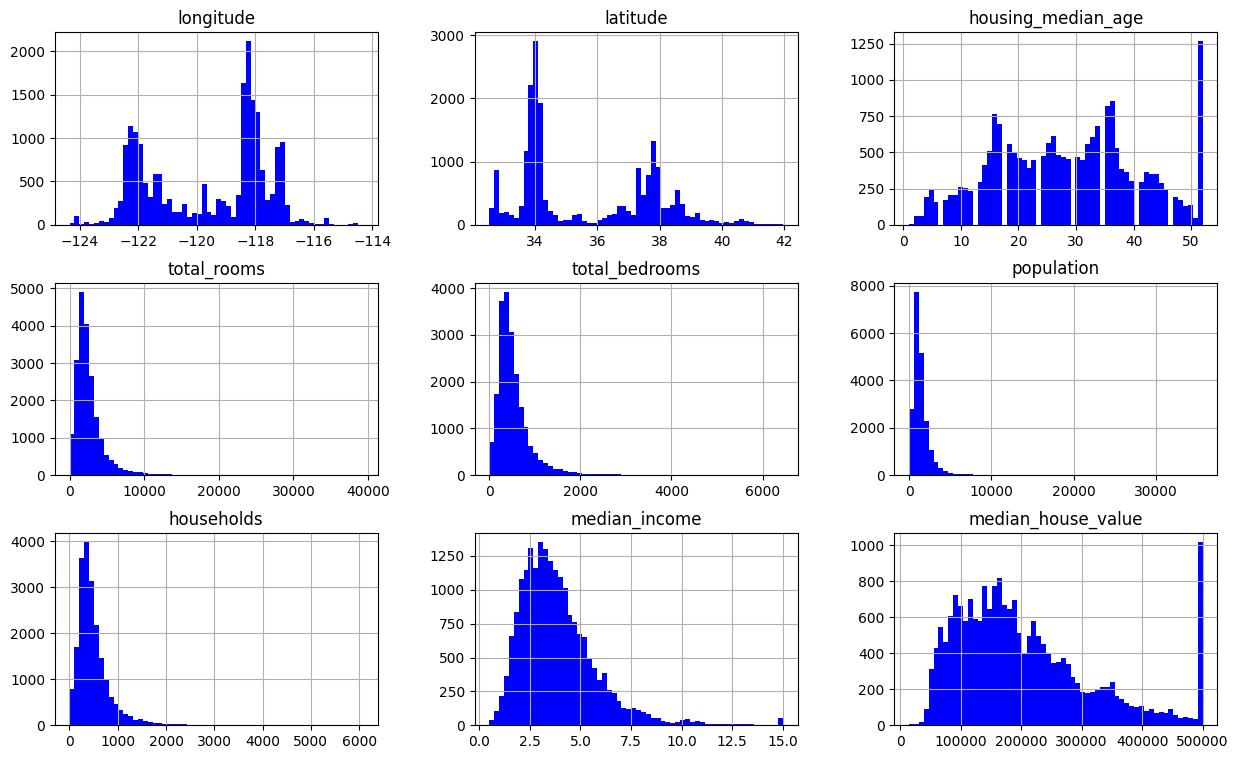

In [5]:
df.hist(bins=60, figsize=(15,9),color="b")
plt.show()

- Most distributions are strongly skewed.
- It seems that median income, housing median age and median house value are capped at certain values.

<ipython-input-6-5f401bac9791>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


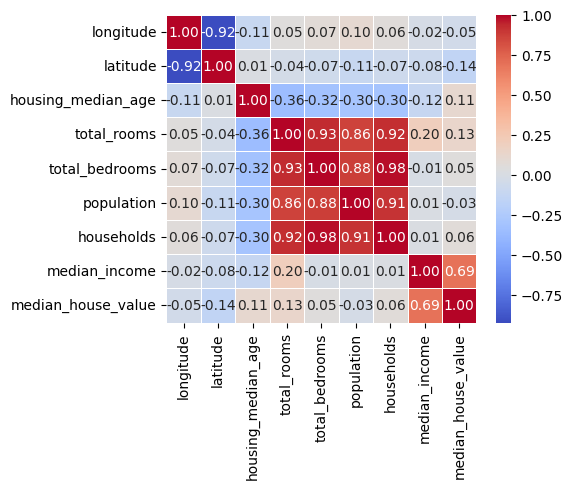

In [6]:
corr_matrix = df.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

- There is quite strong correlation between median house value and median income. Richer people buy more expensive houses.

- Total rooms, total bedrooms, population and households all express very similar information about size of the block.

- There is a negative correlation between longitude and latitude. Corresponds to the geografical shape of California.

In [7]:
# ocean proximity is the only categorical value, we encode it using one hot encoding
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(df[["ocean_proximity"]]).toarray()
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(["ocean_proximity"]))
df = df.reset_index()
one_hot_encoded_df = one_hot_encoded_df.reset_index()
df = pd.concat([df, one_hot_encoded_df], axis=1)
df = df.drop(["ocean_proximity"], axis=1)
df.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,index,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0.0,0.0,0.0,1.0,0.0
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,1,0.0,0.0,0.0,1.0,0.0
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,2,0.0,0.0,0.0,1.0,0.0
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3,0.0,0.0,0.0,1.0,0.0
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,4,0.0,0.0,0.0,1.0,0.0


In [8]:
# finally we split the data into train and test set
X = df.drop("median_house_value",axis=1)
y = df["median_house_value"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [9]:
# feature normalization, we do not normalize ocean proximity
scaled_columns = X.columns[~X.columns.str.contains("ocean_proximity")]

scaler = StandardScaler()
X_train[scaled_columns] = scaler.fit_transform(X_train[scaled_columns])
X_test[scaled_columns] = scaler.transform(X_test[scaled_columns])

### Train your classifier(s) and predict the testing data

For the median house value prediction we will test two models: linear regression and decision tree regression.

In [ ]:
# linear regression
linRegModel = LinearRegression()
linRegModel.fit(X_train, y_train)

In [52]:
# we predict the house values for the test set and calculate RMSE
y_pred_lin = linRegModel.predict(X_test)
print("Linear regression RMSE:", np.sqrt(mean_squared_error(y_pred_lin, y_test)))

Linear regression RMSE: 66160.60223027605


In [57]:
# decision tree regression
treeReg = DecisionTreeRegressor(max_depth=8)
treeReg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8)

In [54]:
y_pred_tree = treeReg.predict(X_test)
print("Decision tree regression RMSE:", np.sqrt(mean_squared_error(y_pred_tree, y_test)))

Decision tree regression RMSE: 62368.76058877402


Decision tree regression seems to be slightly more accurate. We assess the models more precisely using cross validation.

In [56]:
neg_MSE_lin = cross_val_score(linRegModel, X, y, scoring="neg_mean_squared_error", cv=5)
neg_MSE_tree = cross_val_score(treeReg, X, y, scoring="neg_mean_squared_error", cv=5)
mean_RMSE_lin = np.sqrt(-neg_MSE_lin).mean()
mean_RMSE_tree = np.sqrt(-neg_MSE_tree).mean()
print("Linear regression mean RMSE:", mean_RMSE_lin)
print("Decision tree regression mean RMSE:", mean_RMSE_tree)

Linear regression mean RMSE: 78244.82307774381
Decision tree regression mean RMSE: 108346.25343814588


Cross validation shows that the performance of decision tree regression is actually worse.

## Discuss the results


The goal of the project was to predict prices of houses in different parts of California using simple dataset from 1990. From the data it was clear that there is a strong correlation between the house price and the income of the household. We used linear regression and decision tree regression to predict the housing prices. In the end linear regression achieved lower prediction error. The decision tree model could probably be improved by different choice of hyperparameters.